In [1]:
# Author: Chase J. Shyu
# Email: iamhemry@gmail.com
# Created date: June 3rd, 2021
# Updated date: June 5th, 2021
import datetime, math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")

In [8]:
# 2021/04台灣人口 23,514,196
# Wikipedia: https://zh.wikipedia.org/zh-tw/臺灣人口
population_202104 = 23514196
vaccine_prec = 0.65
vacNumber = population_202104*vaccine_prec*2
first_date = datetime.datetime.fromisoformat('2021-03-01')
last_date = datetime.datetime.today() #+ datetime.timedelta(days=-1)

# for read data
csv_filename = 'VaccineCOVID19Taiwan - public.csv'
Date = '公布日期'
StatisticDate = '統計日期'
Event = '事件'
InjectedAmount = '校正累計施打'
ConfirmedLocalAmount = '累計本土確診'
ConfirmedLocalDaily = '單日本土確診'
ConfirmedLocalCorrectDaily = '單日本土增補'
DeathAmount = '累計死亡'
DeathDaily = '單日死亡'
ArrivedAmount = '累計疫苗抵臺'

# read data
df = pd.read_csv(csv_filename)
df = df[~df[Date].isnull()]
df.loc[:,Date] = df[Date].astype('datetime64[ns]')
df.loc[:,StatisticDate] = df[StatisticDate].astype('datetime64[ns]')
df['mavg'] = df[InjectedAmount].interpolate()
df.set_index(StatisticDate,inplace=True)
ind = (df.index >= first_date + datetime.timedelta(days=-1)) * (df.index < last_date)
df = df[ind]

#
covid_ylim_max = 800
vac_ylim_times = 1.5
prog_ylim_max = 10
prog_y_interval = 2
figsize = (18, 12)

# for plot
title = '臺灣COVID-19疫苗接種統計報表'
title_prog = '臺灣COVID-19疫苗取得進度'
label_right = '單日本土確診/死亡(人)'
label_left = '累計疫苗接種(%)'
label_bottom = '事件/統計日期(西元)'
label_confirmed = '單日本土確診(人)'
label_death = '單日死亡(人)'
text_population = '臺灣人口基數(2021-04)：'+ f'{population_202104:,}' +'人'
text_last_updated = '最後更新日期：%s'%df.index[-1].strftime('%Y-%m-%d')
confirmedAmount = int(df[ConfirmedLocalAmount].max())
deathDeath = int(df[DeathAmount].max())
text_confirmed_amount = '累計本土確診/死亡：' + f'{confirmedAmount:,}/' + f'{deathDeath:,}' +'人'
text_vaccine_estimation = '假設' + f'{vacNumber:,}' + '劑(總人口x2x%d'%(vaccine_prec*100) + '%)'
text_sign = '資料整理：Chase J. Shyu'

label_sub_bottom = '事件日期(西元)'
label_progress = '疫苗取得(%)'

vaccine_color = 'blue'
death_color = 'red'
confirmd_color = 'pink'
progress_color = 'darkviolet'
progress_axis_color = 'black'
progress_text_color = 'black'
title_size = 36
label_size = 20
tick_size = 16
legend_title_size = 12
subplot_label_size = 12
event_size = 10
main_alpha = 1

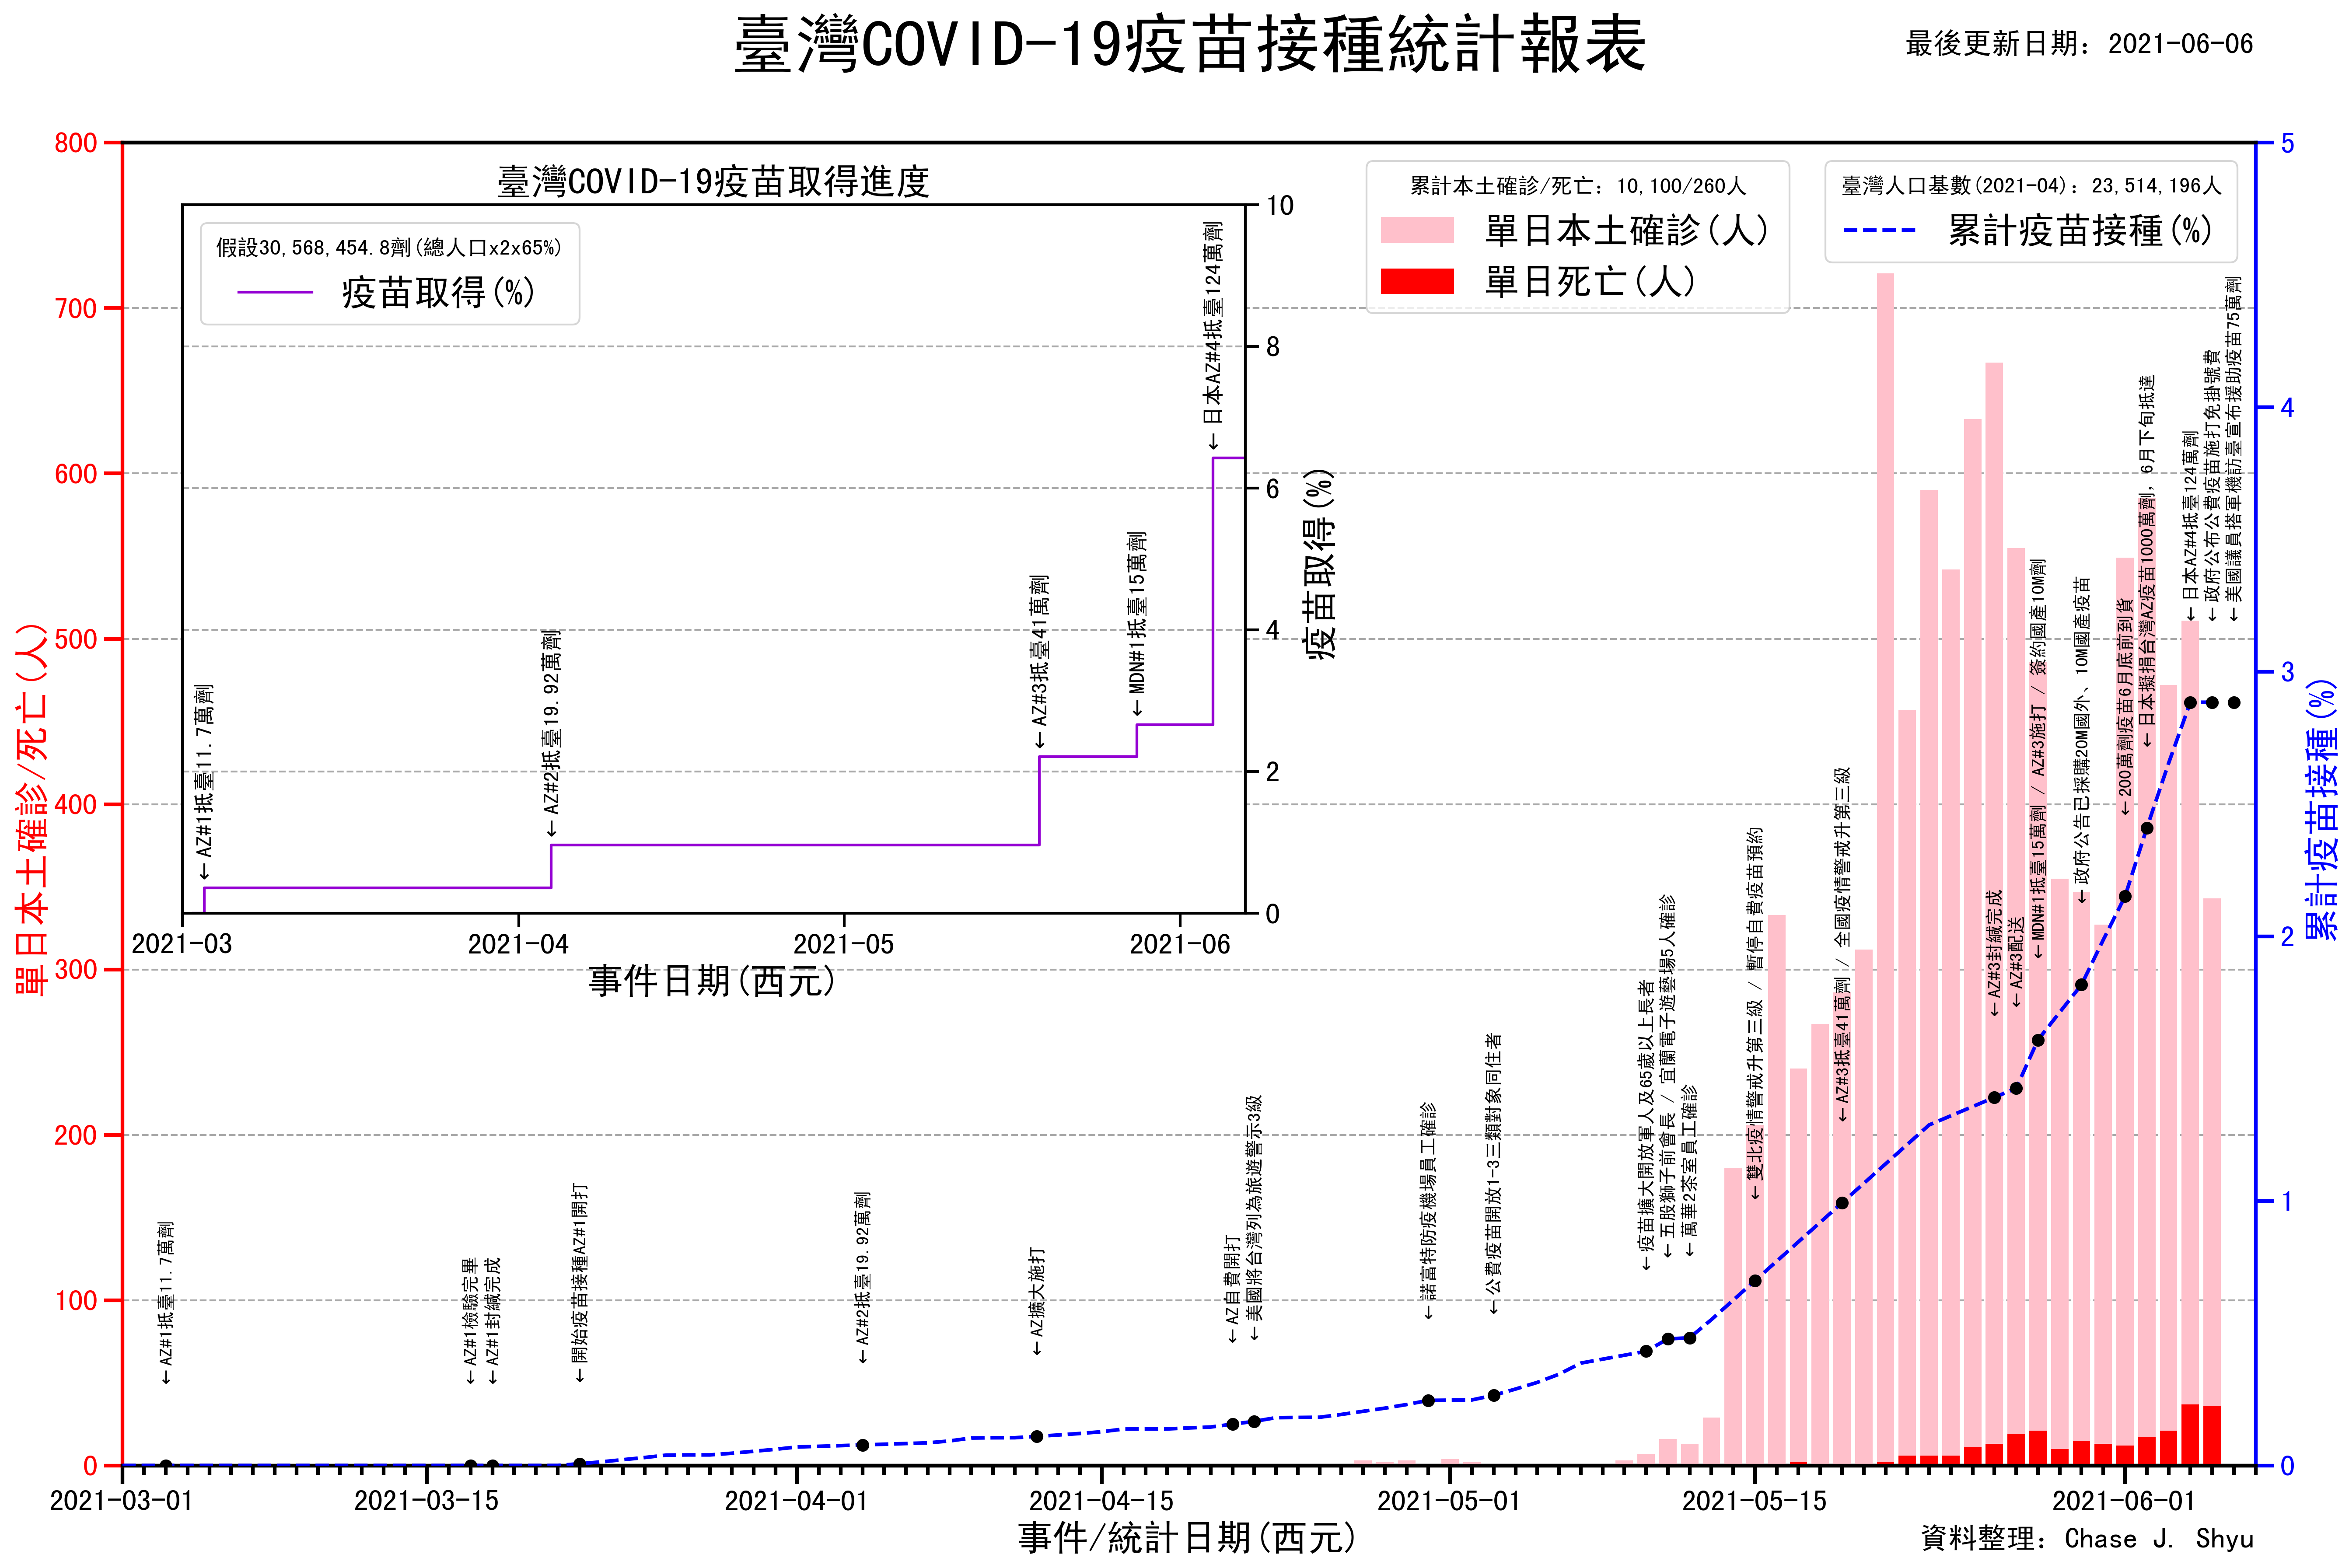

In [12]:
# plot
# https://medium.com/@jackielo_69076/mac-matplotlib-顯示中文-e10c8394300c
#from matplotlib.font_manager import _rebuild
#_rebuild()
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

mpl.rcParams['xtick.labelsize'] = tick_size
mpl.rcParams['ytick.labelsize'] = tick_size
mpl.rcParams['legend.title_fontsize'] = legend_title_size

fig, ax_covid = plt.subplots(1,1,figsize=figsize,dpi=300)
ax_vaccine = ax_covid.twinx()

# plot confirmed case and death
ax_covid.bar(df.index, df[ConfirmedLocalDaily] + df[ConfirmedLocalCorrectDaily],color=confirmd_color,label=label_confirmed,zorder=10)
ax_covid.bar(df.index, df[DeathDaily],color=death_color,label=label_death,zorder=10)

ax_covid.set_ylim(0,covid_ylim_max)
ax_covid.set_ylabel(label_right, fontsize=label_size)
ax_covid.set_xlabel(label_bottom, fontsize=label_size)
ax_covid.spines['left'].set_color(death_color)
ax_covid.spines['right'].set_visible(False)
ax_covid.yaxis.label.set_color(death_color)
ax_covid.tick_params(axis='y',colors=death_color)
for axis in ['top','bottom','left','right']:
    ax_covid.spines[axis].set_linewidth(2)
ax_covid.tick_params(which='major', length=10, width=2)
ax_covid.tick_params(which='minor', length=5, width=2)
ax_covid.patch.set_alpha(main_alpha)
ax_covid.grid(axis='y',linestyle = '--', linewidth = 1,zorder=0,color='darkgray')


# plot vaccine injected amount
ind = (~df[InjectedAmount].isnull()) & (df.index < (last_date + datetime.timedelta(days=-1)))
ax_vaccine.plot(df.index[ind], df[InjectedAmount][ind]/population_202104*100,
                '--',color=vaccine_color, linewidth = 2,label=label_left,zorder=10)

# text event information
y_shift = ax_vaccine.get_ylim()[1]*0.1
ind = ~df[Event].isnull() & (df[Date] < last_date)
date = df.loc[ind,Date]
for i in df[ind].index:
    ycoord = df.loc[date[i],'mavg'] / population_202104*100 + y_shift
    ax_vaccine.text(df.loc[i,Date],ycoord,'$\leftarrow$'+ df.loc[i,Event],
                    rotation=90,fontsize=event_size,horizontalalignment='center',zorder=10)
ax_vaccine.plot(df.loc[ind,Date], df["mavg"][date]/population_202104*100 ,'o',color='black',zorder=10)

ax_vaccine.set_zorder(0)
ax_vaccine.set_ylim(0,math.ceil(ax_vaccine.get_ylim()[1] * vac_ylim_times))
ax_vaccine.set_xlim(first_date,df.index[-1]+datetime.timedelta(days=1))
ax_vaccine.set_ylabel(label_left, fontsize=label_size)
ax_vaccine.set_title(title,fontsize=title_size,y=1.05)
ax_vaccine.text(last_date,ax_vaccine.get_ylim()[1]*1.065,
                text_last_updated,
               fontsize=tick_size,ha='right',va='bottom')
ax_vaccine.text(last_date,-ax_vaccine.get_ylim()[1]*0.065,text_sign,fontsize=tick_size,ha='right',va='bottom')
#ax_vaccine.spines['top'].set_visible(False)
ax_vaccine.spines['left'].set_visible(False)
ax_vaccine.spines['right'].set_color(vaccine_color)
for axis in ['top','bottom','left','right']:
    ax_vaccine.spines[axis].set_linewidth(2)
ax_vaccine.yaxis.label.set_color(vaccine_color)
ax_vaccine.tick_params(axis='y',colors=vaccine_color)
ax_vaccine.xaxis.set_minor_locator(mdates.DayLocator())
ax_vaccine.tick_params(which='major', length=10, width=2)
ax_vaccine.patch.set_alpha(main_alpha)

# plot vaccine progress
ax_progress = fig.add_axes([0.08, 0.42, .45, 0.45])
ax_progress.set_xlim(first_date,df.index[-1]+datetime.timedelta(days=1))
ax_progress.set_ylim(0,prog_ylim_max)

dd = np.vstack((df[Date][:-1],df[Date][1:])).T.reshape((1,-1),)[0]
aa = np.vstack((df[ArrivedAmount][:-1],df[ArrivedAmount][:-1])).T.reshape((1,-1),)[0]
ax_progress.plot(dd,aa / (population_202104*0.7*2) * 100,'-',color=progress_color,label=label_progress)

y_shift = ax_vaccine.get_ylim()[1]*0.02
ind = ~df[Event].isnull()
date = df.loc[ind,Date]
for i in df[ind].index:
    if '抵臺' in df.loc[i,Event]:
        ycoord = df.loc[date[i],ArrivedAmount] / (population_202104*0.7*2) * 100 + y_shift
        ax_progress.text(df.loc[i,Date],ycoord,'$\leftarrow$'+ df.loc[i,Event].split('/')[0],
                        rotation=90,fontsize=event_size+2,horizontalalignment='center',color=progress_text_color)

ax_progress.set_title(title_prog,fontsize=label_size)
ax_progress.patch.set_alpha(1)
ax_progress.yaxis.tick_right()
ax_progress.yaxis.set_label_position("right")
ax_progress.set_xlabel(label_sub_bottom,fontsize=label_size)
ax_progress.set_ylabel(label_progress,fontsize=label_size)
ax_progress.set_yticks(np.arange(0, prog_ylim_max+.1, prog_y_interval))
ax_progress.tick_params(axis='y',labelsize=tick_size)
ax_progress.set_zorder(2)

for axis in ['top','bottom','left','right']:
    ax_progress.spines[axis].set_linewidth(1.5)
    ax_progress.spines[axis].set_color(progress_axis_color)
    
ax_progress.tick_params(which='major', length=7.5, width=1.5)
ax_progress.xaxis.set_major_locator(mdates.MonthLocator())
ax_progress.xaxis.label.set_color(progress_text_color)
ax_progress.yaxis.label.set_color(progress_text_color)
ax_progress.tick_params(axis='both',colors=progress_axis_color)
ax_progress.grid(axis='y',linestyle = '--', linewidth = 1,color='darkgray')

ax_covid.legend(loc=1,bbox_to_anchor=(0.79, 1),fontsize=label_size,title=text_confirmed_amount)
ax_vaccine.legend(loc=1,bbox_to_anchor=(1, 1),fontsize=label_size,title=text_population)
ax_progress.legend(loc=2,fontsize=label_size,title=text_vaccine_estimation)

# save figure
plt.tight_layout()
plt.savefig('VaccineCOVID19Taiwan-%s.jpg'%df.index[-1].strftime('%Y-%m-%d'),dpi=300)
plt.show()
plt.close()